# Milestone Project 1: Food Vision Big

## Check GPU

* A100![2024-01-31 (1).png](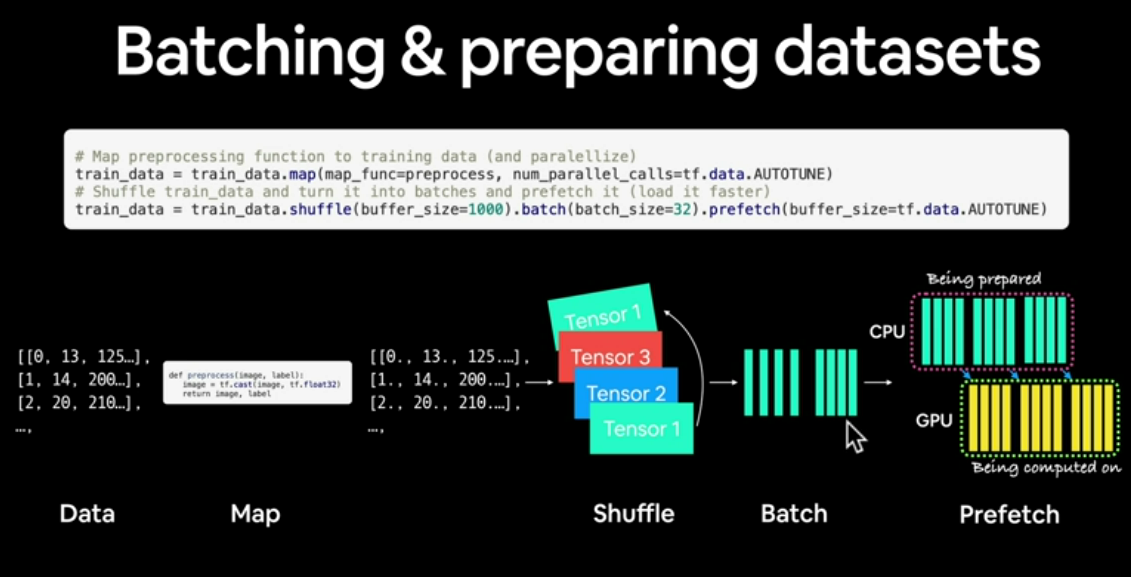![2024-01-31 (1).png](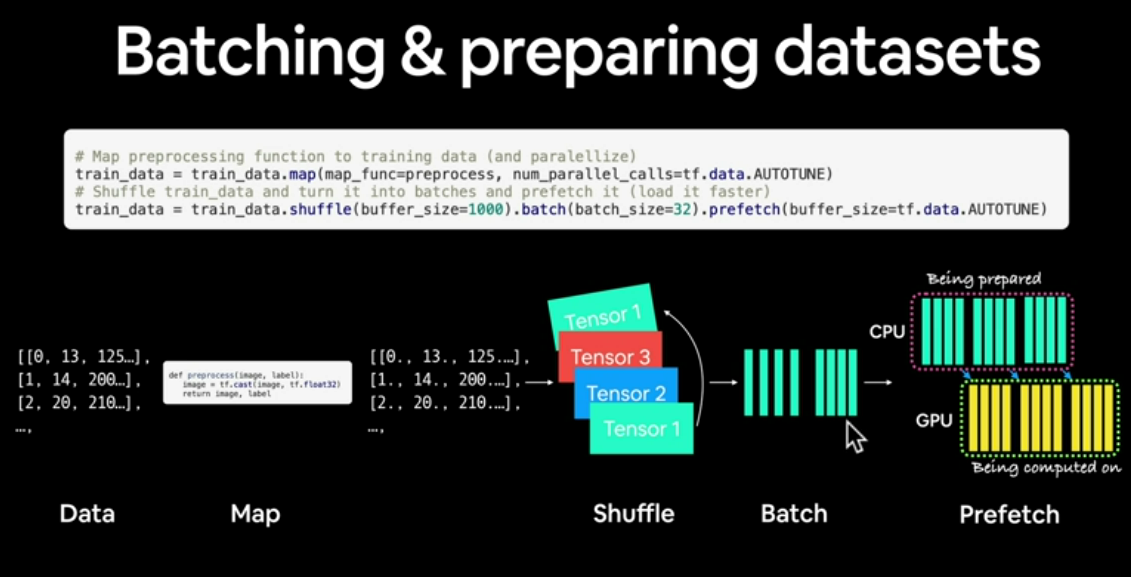![2024-01-31 (3).png](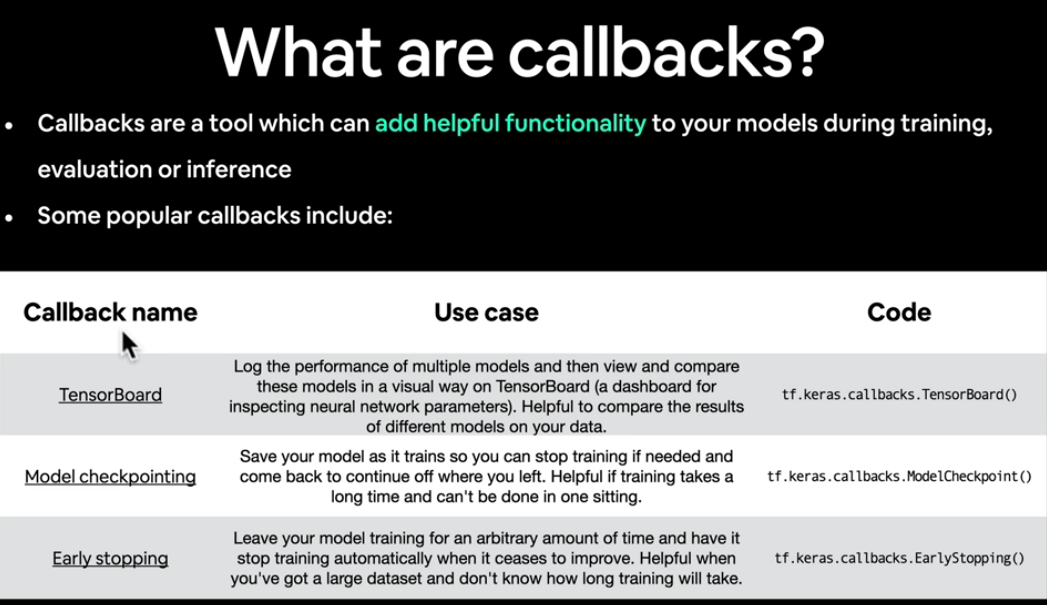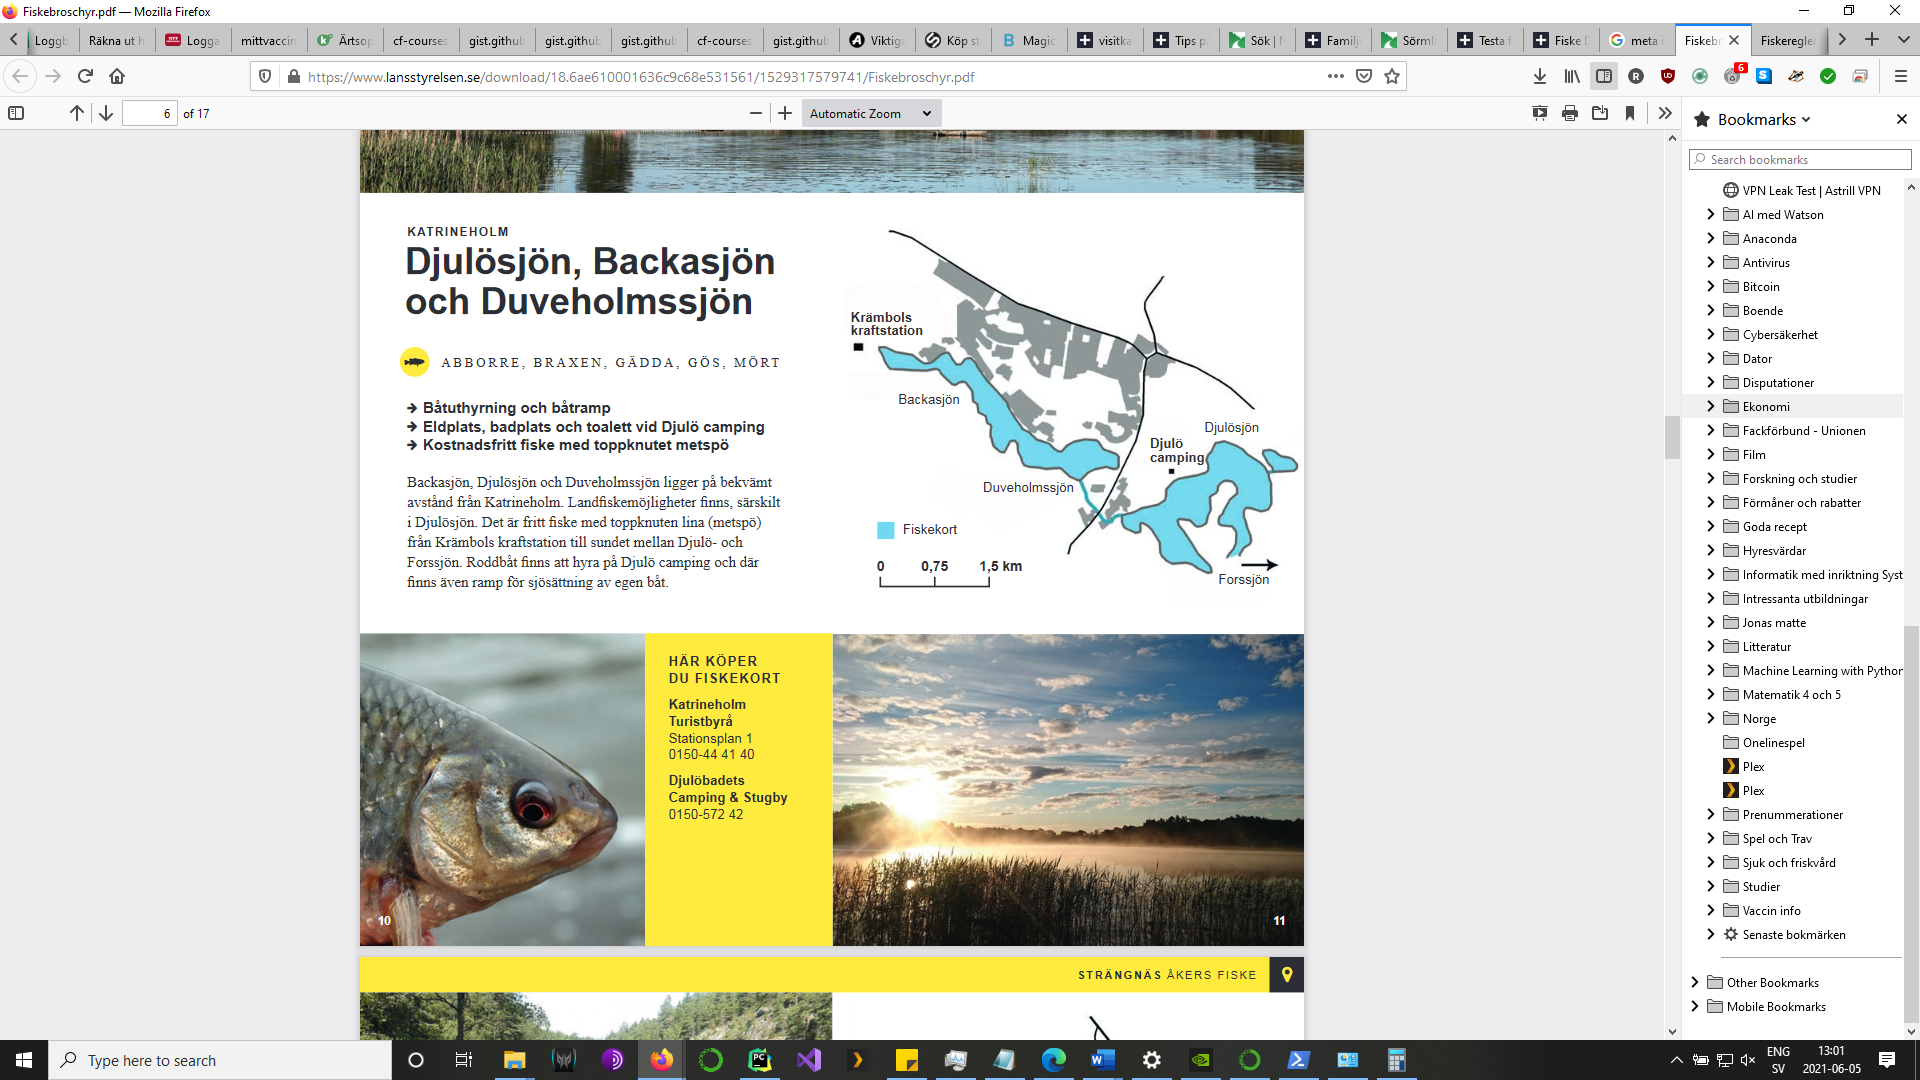)))
* T4
* V100


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4029f379-a330-d1d7-30f9-db5e5ec12d66)


In [2]:
# Get helper functions (Download helper functions script from JonasHagstrom79/Tensorflow(raw))
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py



--2024-01-31 19:23:13--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13380 (13K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  13.07K  --.-KB/s    in 0.002s  

2024-01-31 19:23:13 (6.20 MB/s) - ‘helper.py’ saved [13380/13380]



In [3]:
# Import series of helper functions
from helper import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow datasets to download data

If you want to get an overwiev of TensorFlow Datasets (TFDS), read the [guide](https://www.tensorflow.org/datasets/overview)

In [4]:
# Get TensorFllow Datasets
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders() # Get all available datasets in TFDS
print('food101' in datasets_list)

True


In [34]:
# Load in the food101 (takes 5-6 minutes)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Data gets returned in tuple format (data, label)
                                                    with_info=True) # Downloads the metadata aswell (ds_info makes it possible)

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our inut data
* What the labels look like (e.g are they one-hot encoded or are they label encoded)
* Do the labels match p with the class names?

In [6]:
# Fetures of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Take one sample of the training data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Output info about our trainig sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from food101 (tensor form): 77
  Class name (str form): pork_chop
  


In [10]:
# What does our image tensor from TFDS's Food101 loo like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [11]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow datasets

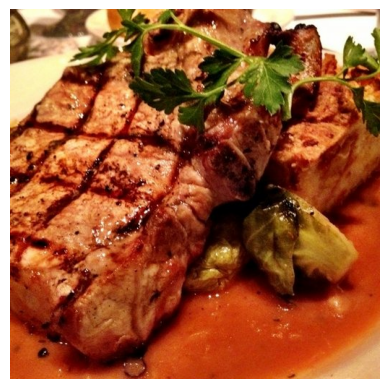

In [12]:
# Plot an image tensor
import matplotlib.pyplot as plt
# Convert the TensorFlow image tensor to NumPy array
image_np = image.numpy()
# Display the image using Matplotlib
plt.imshow(image_np)
plt.axis('off') # Optional: Turn off axis labels
plt.show()

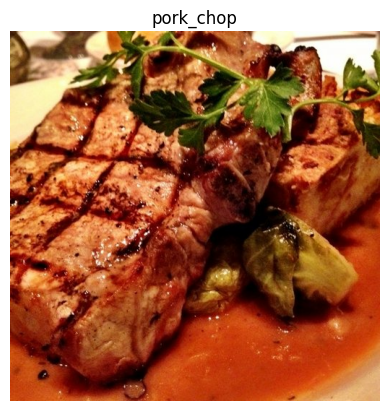

In [13]:
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With thes points in mind, we've got a few things we can tackle with a preprocessing function.

In [28]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224): # Since its a tuple we need image, label
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) #reshape target image
  image = image /255.0 # Rescale image to the range [0, 1]
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple


In [29]:
# Preprocess a single sampple image and check the outputs
preprocessed_img = preprocess_img(image, label)[0] # [0] for the 0th index of the tuple we're returning
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[0.27330932 0.12821129 0.06546619]
  [0.30764306 0.16254501 0.08831533]
  [0.30726293 0.16692677 0.06328531]
  ...
  [0.82879037 0.6545608  0.55568135]
  [0.67600936 0.49953878 0.40934268]
  [0.5413358  0.36486524 0.28251228]]

 [[0.2497799  0.11094438 0.04117646]
  [0.23583435 0.09857943 0.01288515]
  [0.26878753 0.13131253 0.02038815]
  ...
  [0.81650597 0.6438969  0.53633404]
  [0.72294825 0.55091953 0.44611773]
  [0.57518864 0.41048273 0.3127236 ]]]...,
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


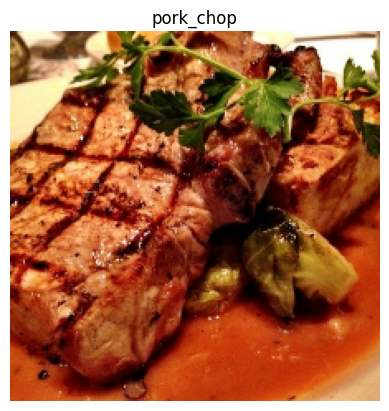

In [32]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img)
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

More [resources](https://www.tensorflow.org/guide/data_performance) on this.

In [35]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # Autotune uses two chips, faster
# Shuffle train data and turn into batches and prefetch it (load faster)
train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # Shuffle is how many elements to shuffle at a single time (1000 if memory not enough)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE).cache()



In [36]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

We're going to create a coupe of callbacks to help us while our model trains:
* `TensorBoard` callbacks to log training results (so we can visualize them later if need be)
* `ModelCheckpoint` callback to save our model's progress after feature extraction

In [38]:
# Create tensorbord callback (import from helper.py)
from helper import create_tensorboard_callback

# Create a ModelCheckpoit callback to save a model's progress during training
checkpoint_path = "model_checkpoints/checkPoint.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=2) # Outputs information, 0=none, 1=little info, 2=most info